In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision import models
from torchsummary import summary
from sklearn.model_selection import train_test_split

In [21]:
batch_size = 32
device = torch.device("mps")
loss_criterion = nn.CrossEntropyLoss()

In [22]:
# Function to train and calculate loss and accuracy for one epoch
def train(epoch, train_load, model, optimizer):
    training_loss = 0
    training_accuracy = 0

    # Training mode
    model.train()
    for (X_train, y_train) in train_load:
        # Move features and labels to GPU (Metal - mps)
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # Forward
        training_scores = model(X_train)
        loss = loss_criterion(training_scores, y_train)
        training_loss += loss.item()
        training_accuracy += (training_scores.argmax(1) == y_train).sum().item()

        # Clear grads
        optimizer.zero_grad()

        # Backward
        loss.backward()

        # Gradient descent
        optimizer.step()

    # Calculate epoch loss and accuracy
    training_loss = training_loss / len(train_load)
    training_accuracy = training_accuracy / len(train_load.dataset)
    return training_loss, training_accuracy, model

def test(epoch, val_load, model):
    validation_loss = 0
    validation_accuracy = 0

    # Eval mode
    with torch.no_grad():
        model.eval()
        for (X_val, y_val) in val_load:
            # Move features and labels to GPU (Metal - mps)
            X_val = X_val.to(device)
            y_val = y_val.to(device)

            # Forward
            validation_scores = model(X_val)
            loss = loss_criterion(validation_scores, y_val)
            validation_loss += loss.item()
            validation_accuracy += (validation_scores.argmax(1) == y_val).sum().item()

    # Calculate epoch loss and accuracy
    validation_loss = validation_loss / len(val_load)
    validation_accuracy = validation_accuracy / len(val_load.dataset)
    return validation_loss, validation_accuracy

# Function to perform a full training run
def perform_training(model, optimizer, num_of_epochs, train_load, val_load, patience=3, early_stopping=False):
    # Train the model
    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []

    # Early stopping trackers
    trigger_times = 0
    current_val_accuracy = 0
    best_epoch = 0

    for epoch in range(num_of_epochs):
        # Train model and keep track of losses
        training_loss, training_accuracy, model = train(
            epoch, train_load, model, optimizer)
        validation_loss, validation_accuracy = test(epoch, val_load, model)

        # Track early stopping condition
        if validation_accuracy < current_val_accuracy:
            trigger_times += 1
        else:
            current_val_accuracy = validation_accuracy
            best_epoch = epoch
            trigger_times = 0

        if (trigger_times == patience) and early_stopping:
            print("Early stopped!")
            break

        training_losses.append(training_loss)
        validation_losses.append(validation_loss)
        training_accuracies.append(training_accuracy)
        validation_accuracies.append(validation_accuracy)

        print("Epoch", epoch + 1)
        display_results(training_loss, validation_loss,
                        training_accuracy, validation_accuracy)

    if (trigger_times == patience) and early_stopping:
        training_losses = training_losses[0:best_epoch + 1].copy()
        validation_losses = validation_losses[0:best_epoch + 1].copy()
        training_accuracies = training_accuracies[0:best_epoch + 1].copy()
        validation_accuracies = validation_accuracies[0:best_epoch + 1].copy()
    return (model, training_losses, validation_losses, training_accuracies, validation_accuracies)

# Function to display losses and accuracies (both training and validation)
def display_results(training_loss, validation_loss, training_accuracy, validation_accuracy):
    print("--------------------------------------")
    print("Train loss =", round(training_loss, 4))
    print("Validation loss =", round(validation_loss, 4))
    print("Training Acc =", round(training_accuracy, 4))
    print("Validation Acc =", round(validation_accuracy, 4))
    print("--------------------------------------")

# Function to show plots of losses and accuracies (both training and validation)
def show_plot(training_losses, validation_losses, training_accuracies, validation_accuracies):
    x_training = np.arange(1, len(training_losses) + 1)
    x_validation = np.arange(1, len(validation_losses) + 1)
    plt.plot(x_training, training_losses, marker='.', label="Training loss")
    plt.plot(x_training, validation_losses,
             marker='.', label="Validation loss")
    plt.plot(x_validation, training_accuracies,
             marker='.', label="Training accuracy")
    plt.plot(x_validation, validation_accuracies,
             marker='.', label="Validation accuracy")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss and Accuracy")
    plt.xticks(x_training)
    plt.show()

# Function to show images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [23]:
from torchvision.models import vgg19, resnet18, VGG19_Weights, ResNet18_Weights

# Define weights and transforms
vgg_weights = VGG19_Weights.DEFAULT
vgg_transforms = vgg_weights.transforms()
resnet_weights = ResNet18_Weights.DEFAULT
resnet_transforms = resnet_weights.transforms()

In [33]:
# Full training set
full_train_data_vgg = datasets.CIFAR10(
    root="dataset/", train=True, transform=vgg_transforms, download=True)
full_train_load_vgg = DataLoader(
    dataset=full_train_data_vgg, batch_size=batch_size, shuffle=True)

# Generating reduced training and validation sets
train_data_count = int(len(full_train_data_vgg) * 0.8)
val_data_count = len(full_train_data_vgg) - train_data_count
train_data_vgg, val_data_vgg = random_split(full_train_data_vgg,
                                    [train_data_count, val_data_count],
                                    generator=torch.Generator().manual_seed(42))
train_load_vgg = DataLoader(
    dataset=train_data_vgg, batch_size=batch_size, shuffle=True)
val_load_vgg = DataLoader(
    dataset=val_data_vgg, batch_size=batch_size, shuffle=True)

# Test set
test_data_vgg = datasets.CIFAR10(
    root="dataset/", train=False, transform=vgg_transforms, download=True)
test_load_vgg = DataLoader(
    dataset=test_data_vgg, batch_size=batch_size, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


In [36]:
# Full training set
full_train_data_resnet = datasets.CIFAR10(
    root="dataset/", train=True, transform=resnet_transforms, download=True)
full_train_load_resnet = DataLoader(
    dataset=full_train_data_resnet, batch_size=batch_size, shuffle=True)

# Generating reduced training and validation sets
train_data_count = int(len(full_train_data_resnet) * 0.8)
val_data_count = len(full_train_data_resnet) - train_data_count
train_data_resnet, val_data_resnet = random_split(full_train_data_resnet,
                                            [train_data_count, val_data_count],
                                            generator=torch.Generator().manual_seed(42))
train_load_resnet = DataLoader(
    dataset=train_data_resnet, batch_size=batch_size, shuffle=True)
val_load_resnet = DataLoader(
    dataset=val_data_resnet, batch_size=batch_size, shuffle=True)

# Test set
test_data_resnet = datasets.CIFAR10(
    root="dataset/", train=False, transform=resnet_transforms, download=True)
test_load_resnet = DataLoader(
    dataset=test_data_resnet, batch_size=batch_size, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


In [44]:
# Define models using pre-trained weights and transforms
vgg19_model = vgg19(weights=vgg_weights, progress=True)
resnet18_model = resnet18(weights=ResNet18_Weights, progress=True)
vgg19_model.classifier[6] = nn.Linear(4096, 10)
resnet18_model.fc = nn.Linear(512, 10)

print(vgg19_model)
print(resnet18_model)


/Users/tashrequehaq/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [34]:
vgg19_model = vgg19_model.to(device)
model_information_vgg = perform_training(
    vgg19_model, torch.optim.SGD(vgg19_model.parameters(), lr=0.01), 3, full_train_load_vgg, val_load_vgg, early_stopping=True, patience=4)
trained_model_vgg = model_information_vgg[0]
training_losses_vgg = model_information_vgg[1]
validation_losses_vgg = model_information_vgg[2]
training_accuracies_vgg = model_information_vgg[3]
validation_accuracies_vgg = model_information_vgg[4]


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x14df17300>
    label = <none> 
    device = <AGXG13XDevice: 0x11f5cee00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x14fdc2600>
        label = <none> 
        device = <AGXG13XDevice: 0x11f5cee00>
            name = Apple M1 Pro 
    retainedReferences = 1


Epoch 1
--------------------------------------
Train loss = 0.4804
Validation loss = 0.2456
Training Acc = 0.8352
Validation Acc = 0.9179
--------------------------------------


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG13XFamilyCommandBuffer: 0x2b9219480>
    label = <none> 
    device = <AGXG13XDevice: 0x11f5cee00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x14fdc2600>
        label = <none> 
        device = <AGXG13XDevice: 0x11f5cee00>
            name = Apple M1 Pro 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Caused GPU Hang Error (00000003:kIOGPUCommandBufferCallbackErrorHang)
	<AGXG13XFamilyCommandBuffer: 0x2b92a87e0>
    label = <none> 
    device = <AGXG13XDevice: 0x11f5cee00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x14fdc2600>
        label = <none

Epoch 2
--------------------------------------
Train loss = 0.2386
Validation loss = 0.216
Training Acc = 0.9179
Validation Acc = 0.9247
--------------------------------------


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x2c71c6ea0>
    label = <none> 
    device = <AGXG13XDevice: 0x11f5cee00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x14fdc2600>
        label = <none> 
        device = <AGXG13XDevice: 0x11f5cee00>
            name = Apple M1 Pro 
    retainedReferences = 1


Epoch 3
--------------------------------------
Train loss = 0.1574
Validation loss = 0.0891
Training Acc = 0.9451
Validation Acc = 0.9727
--------------------------------------


In [37]:
resnet18_model = resnet18_model.to(device)
model_information_resnet = perform_training(
    resnet18_model, torch.optim.SGD(resnet18_model.parameters(), lr=0.01), 3, full_train_load_resnet, val_load_resnet, early_stopping=True, patience=4)
trained_model_resnet = model_information_resnet[0]
training_losses_resnet = model_information_resnet[1]
validation_losses_resnet = model_information_resnet[2]
training_accuracies_resnet = model_information_resnet[3]
validation_accuracies_resnet = model_information_resnet[4]


Epoch 1
--------------------------------------
Train loss = 0.4229
Validation loss = 0.1297
Training Acc = 0.8601
Validation Acc = 0.9634
--------------------------------------
Epoch 2
--------------------------------------
Train loss = 0.1713
Validation loss = 0.069
Training Acc = 0.9425
Validation Acc = 0.9808
--------------------------------------
Epoch 3
--------------------------------------
Train loss = 0.0948
Validation loss = 0.0274
Training Acc = 0.969
Validation Acc = 0.9942
--------------------------------------


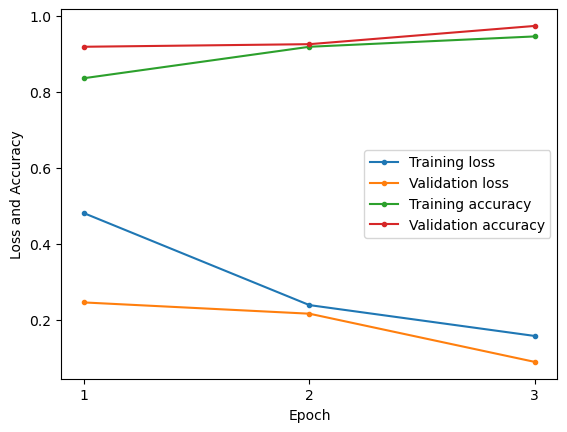

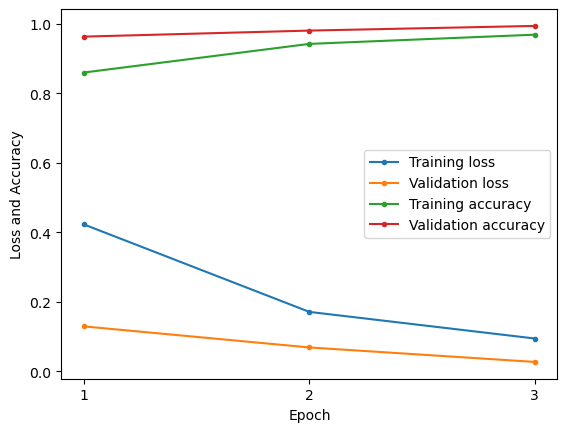

In [38]:
# Plot graph
show_plot(training_losses_vgg, validation_losses_vgg,
          training_accuracies_vgg, validation_accuracies_vgg)
# Plot graph
show_plot(training_losses_resnet, validation_losses_resnet,
          training_accuracies_resnet, validation_accuracies_resnet)

### Testing VGG19 and ResNet18 on the test set.

In [39]:
# Test VGG19
test_loss_vgg, test_accuracy_vgg = test(0, test_load_vgg, vgg19_model)

# Test ResNet18
test_loss_resnet, test_accuracy_resnet = test(0, test_load_resnet, resnet18_model)


In [43]:
print("Test accuracy for VGG19 =", test_accuracy_vgg)
print("Test loss for VGG19 =", test_loss_vgg)
print("Test accuracy for ResNet18 =", test_accuracy_resnet)
print("Test loss for ResNet18 =", test_loss_resnet)

Test accuracy for VGG19 = 0.9177
Test loss for VGG19 = 0.23798906557952254
Test accuracy for ResNet18 = 0.9406
Test loss for ResNet18 = 0.17491782848952345
